# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

### Step 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
# Load calibration images
calibrationImages = list(map(lambda imageFileName : (imageFileName, cv2.imread(imageFileName)), glob.glob('./camera_cal/c*.jpg')))

In [44]:
# display images on a subplot grid
def showImages(images, cols , rows , figsize, cmap=None):
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize = figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap)
            ax.set_title(imagePathName)

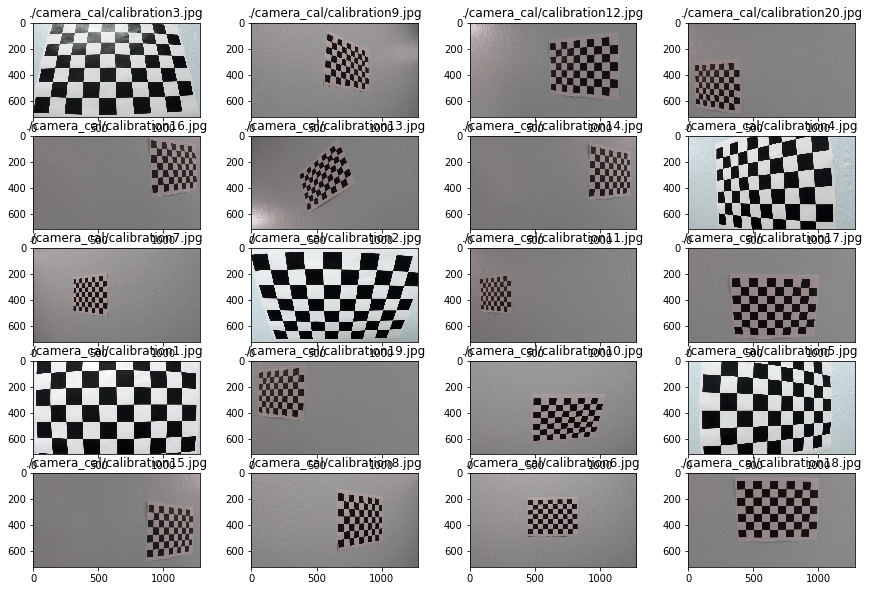

In [45]:
showImages(calibrationImages, 4, 5, (15,10))

In [5]:
objpoints = []
imgpoints = []
outimages = []
originalimages = []

objp = np.zeros((6*9,3), np.float32)
objp[:, :2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
# print(objp)

for imageAndFile in calibrationImages:
    fileName, image = imageAndFile
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        img_points = cv2.drawChessboardCorners(image.copy(), (9,6), corners, ret)
        outimages.append(img_points)
        originalimages.append(image)
    
# print('Image with corner found: {}', format(len(outimages)))
print('Image with corner found: {}'.format(len(outimages)))

Image with corner found: 17


Text(0.5,1,'with_points')

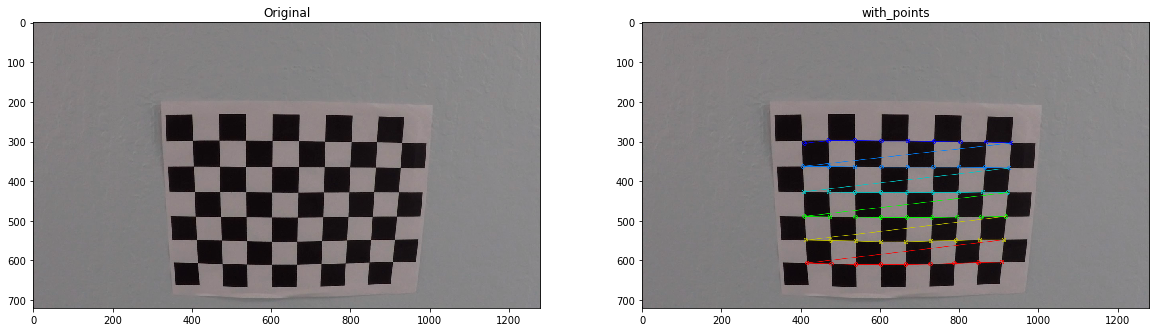

In [6]:
index = 10
original = originalimages[index]
chessPoints = outimages[index]
fig, axes = plt.subplots(ncols=2, figsize=(20,10))
axes[0].imshow(original)
axes[0].set_title('Original')
axes[1].imshow(chessPoints)
axes[1].set_title('with_points')

In [7]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, original.shape[0:2], None, None)
undist = cv2.undistort(original, mtx, dist, None, mtx)

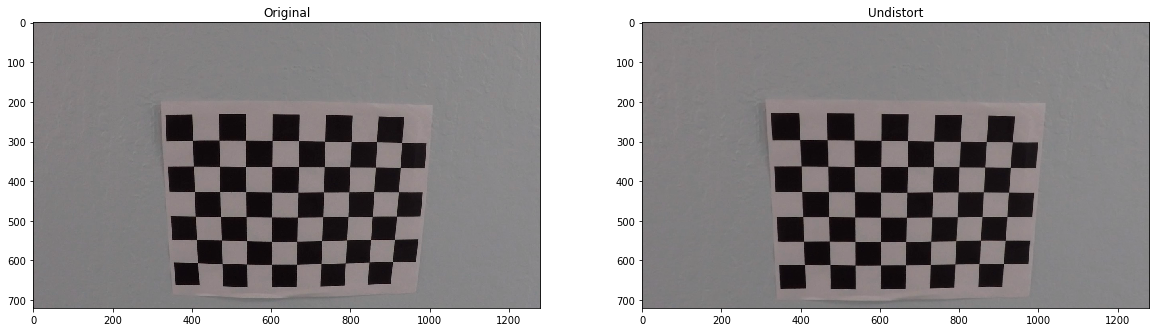

In [224]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(original)
axes[0].set_title('Original')
axes[1].imshow(undist)
axes[1].set_title('Undistort')
plt.savefig('saved_images/calibration.png',dpi=300)

In [9]:

import pickle
pickle.dump( { 'mtx': mtx, 'dist': dist }, open('./pickled_data/camera_calibration.p', 'wb'))

### Sept 2. Apply a distortion correction to raw images

In [46]:
# Load test images.
testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), glob.glob('./test_images/*.jpg')))

In [11]:
# display images on a subplot grid and convert to RGB
def showImagesRGB(images, cols , rows , figsize):
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize = figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
#         if index < imgLength:
        imagePathName, image = images[index]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.set_title(imagePathName)

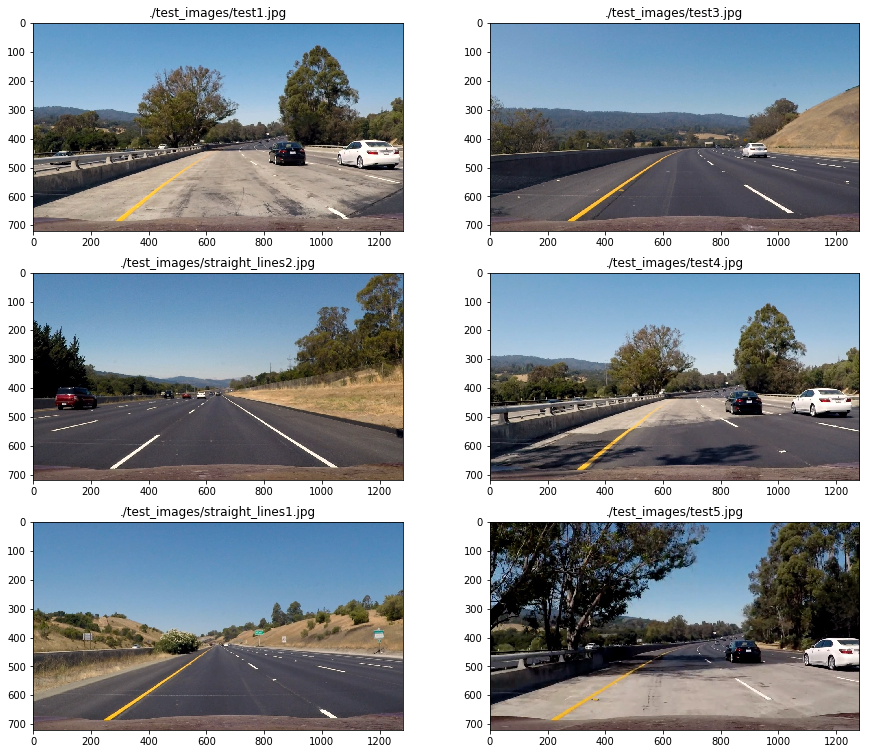

In [12]:
showImagesRGB(testImages, 2, 3, (15,13))

In [13]:
# Apply distortion correction and convert from BGR to RGB.
def DistortionCorrection(image, mtx=mtx, dist=dist):
    return cv2.cvtColor(cv2.undistort(image, mtx, dist, None, mtx), cv2.COLOR_BGR2RGB)

Text(0.5,1,'Undistort')

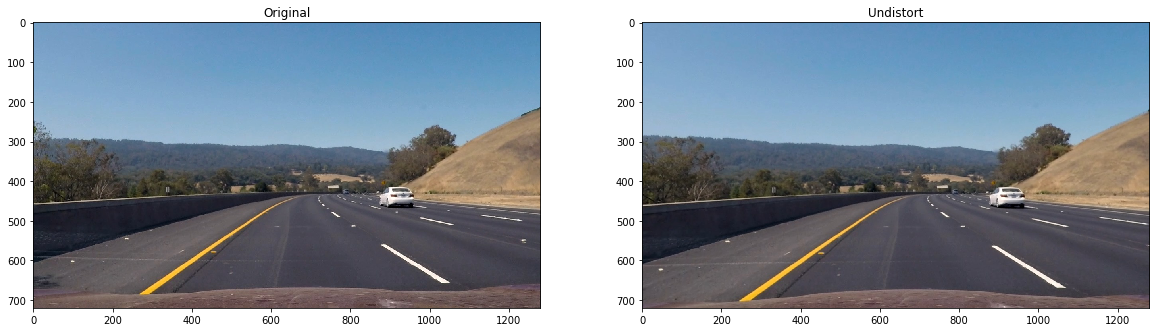

In [14]:
# Display the original figure and undistorted figure.
orginalImage = testImages[1][1]
UndistortImage = DistortionCorrection(orginalImage, mtx, dist)

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(cv2.cvtColor(orginalImage, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[1].imshow(UndistortImage)
axes[1].set_title('Undistort')

### Step 3. Use color transforms, gradients, etc., to create a thresholded binary image.

Colore space

In [137]:
def HLS_Space(image, channel):
    undist = DistortionCorrection(image, mtx, dist)
    return cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)[:,:,channel]

Hchannel = HLS_Space(orginalImage,  1)

Sobel operation

In [138]:
# Abosolote sobel threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Magnitude of gradient threshold
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Direction of gradient threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

Absolote = abs_sobel_thresh(Hchannel, 'x', 3, (0, 255))
mag = mag_threshold(Hchannel, 3, (0, 255))

In [217]:
# Tuning parameters
params = {
    # 0-H, 1-L, 2-S
    'channel': 2, 
    'threshx': (10, 160),
    'threshy': (10, 160),
    'Lthreshx': (5, 255),
    'Lthreshy': (5, 255),    
    'mag_thresh': (30, 170),
    'dir_thresh': (0, np.pi/2)
}

In [218]:
# Combined Sobel operations, need to try different combinations
def Color_Gradients(img, sobel_kernel=3, threshx=params['threshx'], threshy=params['threshy'], 
                    Lthreshx=params['Lthreshx'], Lthreshy=params['Lthreshy'],
                    mag_thresh=params['mag_thresh'], dir_thresh=params['dir_thresh']):
    # Apply each of the thresholding functions
    UndistortImage = DistortionCorrection(img)
    Hchannel = HLS_Space(UndistortImage, 2)
    gradx = abs_sobel_thresh(Hchannel, 'x', sobel_kernel, threshx)
    grady = abs_sobel_thresh(Hchannel, 'y', sobel_kernel, threshy)
    mag_binary = mag_threshold(Hchannel, sobel_kernel, mag_thresh)
    dir_binary = dir_threshold(Hchannel, sobel_kernel, dir_thresh)
    combined = np.zeros_like(grady)
    
    Lchannel = HLS_Space(UndistortImage, 1)
    gradxL = abs_sobel_thresh(Lchannel, 'x', sobel_kernel, Lthreshx)
    gradyL = abs_sobel_thresh(Lchannel, 'y', sobel_kernel, Lthreshy)
#     combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradx == 1) & (grady == 1)) & ((gradxL == 1) & (gradyL == 1))] = 1
    return combined

Text(0.5,1,'Color_Gradient')

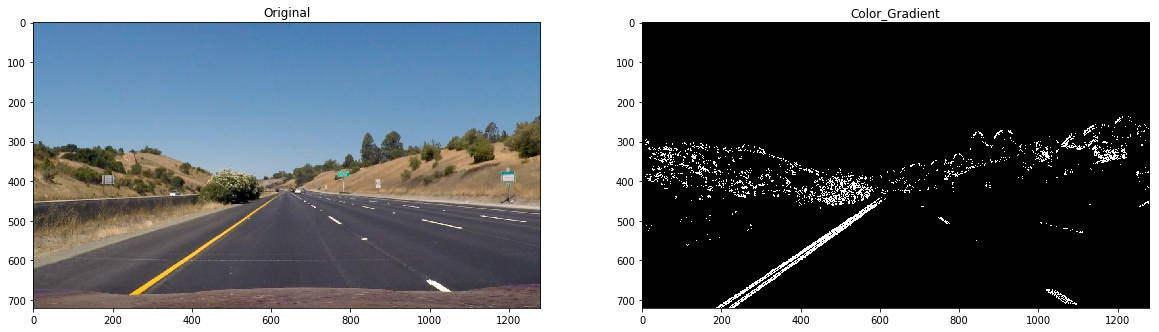

In [212]:
# Display the original figure and undistorted Color Threshold figure.
orginalImage = testImages[4][1]
ColorGradImage = Color_Gradients(orginalImage)

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(cv2.cvtColor(orginalImage, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[1].imshow(ColorGradImage, cmap='gray')
axes[1].set_title('Color_Gradient')

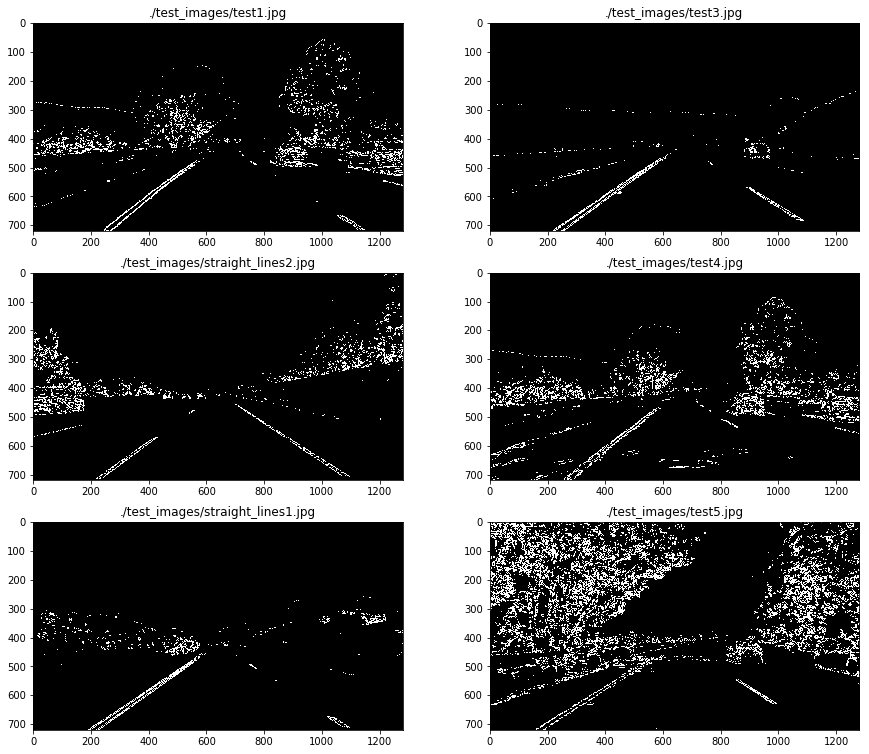

In [170]:
output = list(map(lambda img:(img[0],Color_Gradients(img[1])), testImages))
showImages(output, 2, 3, (15,13), 'gray')

### Step 4. Apply a perspective transform to rectify binary image ("birds-eye view").

720 1280


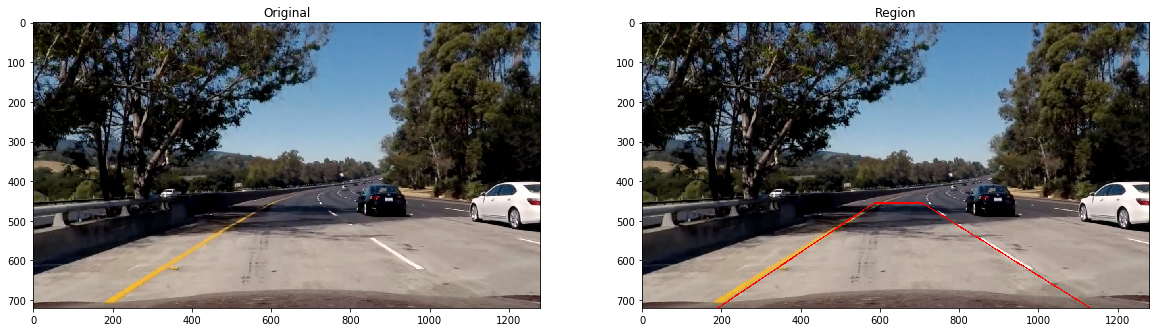

In [144]:
orginalImage = testImages[5][1]
UndistortImage = DistortionCorrection(orginalImage)
undis =UndistortImage.copy()
x_size, y_size, c_size = UndistortImage.shape
l1 = (190, 720)
l2 = (585, 455)
r1 = (705, 455)
r2 = (1130, 720)
color = [255, 0, 0]
w = 2
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(UndistortImage)
axes[0].set_title('Original')
cv2.line(undis, l1, l2, color, w)
cv2.line(undis, l2, r1, color, w)
cv2.line(undis, r1, r2, color, w)
cv2.line(undis, r2, l1, color, w)

axes[1].imshow(undis)
axes[1].set_title('Region')
print(x_size, y_size)

Text(0.5,1,'Region')

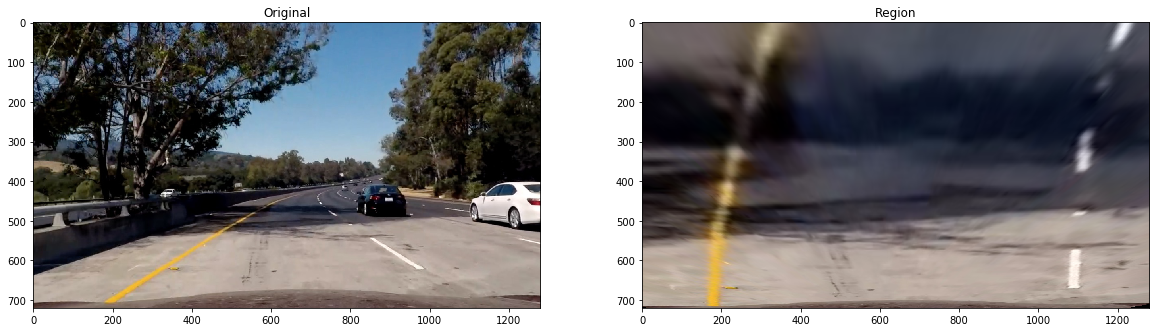

In [145]:
offset = 200
src = np.float32([ 
    [l2[0], l2[1]],
    [r1[0], r1[1]],
    [r2[0], r2[1]],
    [l1[0], l1[1]]
])
dst = np.float32([
    [offset, 0],
    [y_size-offset, 0],
    [y_size-offset, x_size], 
    [offset, x_size]
])
M = cv2.getPerspectiveTransform(src, dst)
MinV = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(UndistortImage, M, (y_size, x_size))

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(UndistortImage)
axes[0].set_title('Original')
axes[1].imshow(warped)
axes[1].set_title('Region')

In [146]:
def Perspective_Transform(img, M = M):
    img_size = (img.shape[1], img.shape[0])
    ColorGradImage = Color_Gradients(img)
    warped = cv2.warpPerspective(ColorGradImage, M, img_size)
    return warped

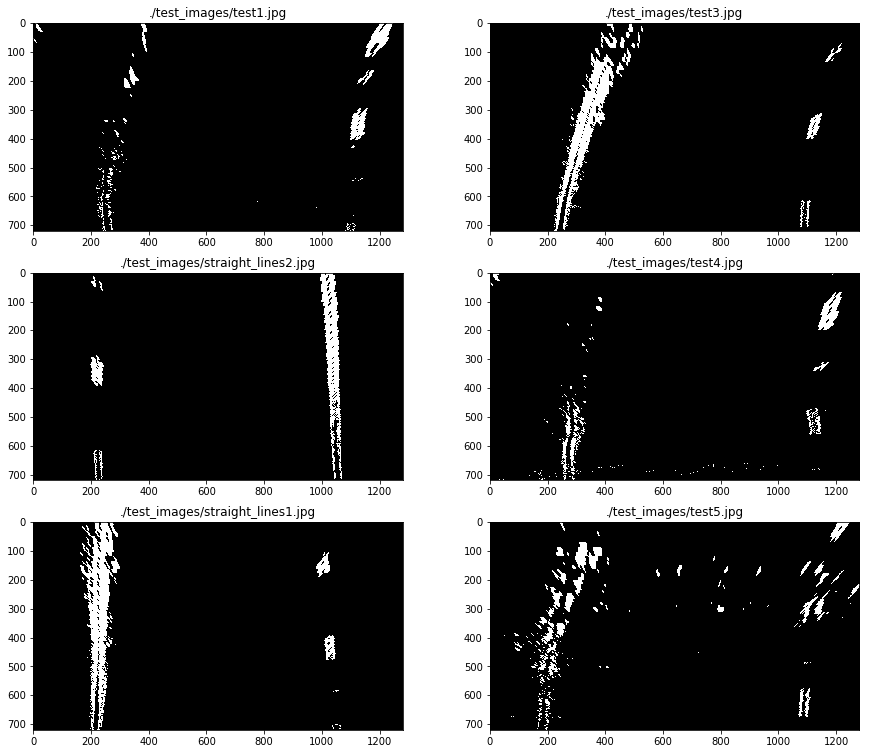

In [219]:
output = list(map(lambda img:(img[0],
                              Perspective_Transform(img[1])), testImages))
showImages(output, 2, 3, (15,13),'gray')

### Step 5. Detect lane pixels and fit to find the lane boundary.

In [148]:
# Tuning parameters
params2 = {
    'nwindows': 9, 
    'margin': 110,
    'minpix': 50
}

In [149]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def detectLane(img, nwindows=params2['nwindows'], margin=params2['margin'], minpix=params2['minpix']):
    warped = Perspective_Transform(img)
   # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)   
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)    

In [150]:
def visualizeLanes(image, ax):

    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = detectLane(image)
    # Visualization
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ax.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    return ( left_fit, right_fit, left_fit_m, right_fit_m )

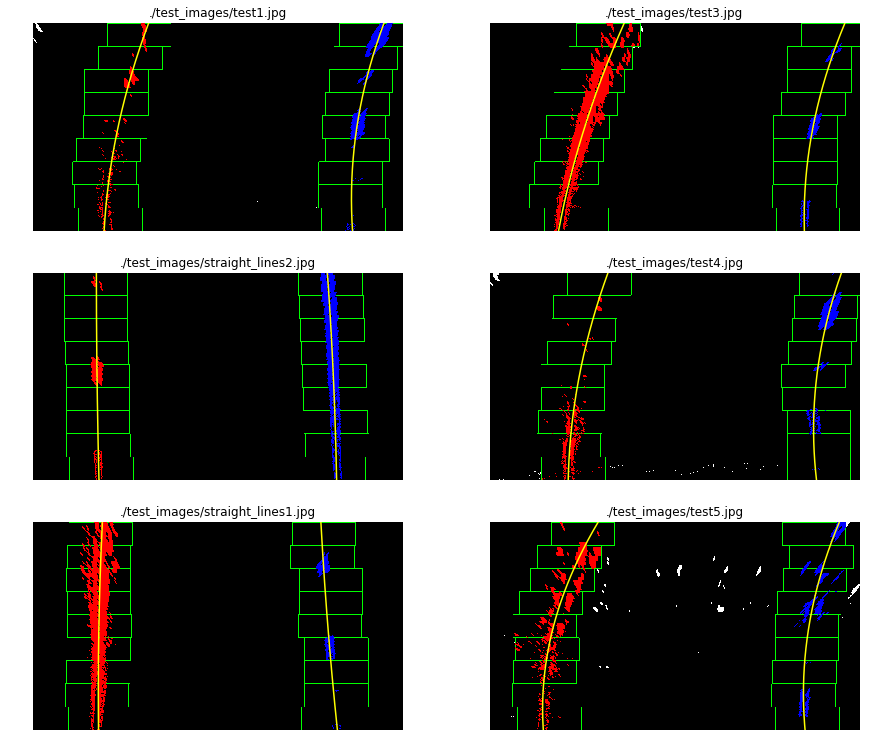

In [220]:
def showLaneOnImages(images, cols = 2, rows = 3, figsize=(15,13)):
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    imageAndFit = []
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            left_fit, right_fit, left_fit_m, right_fit_m = visualizeLanes(image, ax)
            ax.set_title(imagePathName)
            ax.axis('off')
            imageAndFit.append((imagePathName, left_fit, right_fit, left_fit_m, right_fit_m))
    return imageAndFit

imagesLane = showLaneOnImages(testImages)

### Step 6. Determine the curvature of the lane and vehicle position with respect to center.

In [152]:
def calculateCurvature(yRange, left_fit_cr):
    
    return ((1 + (2*left_fit_cr[0]*yRange*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])

for imageLane in imagesLane:
    imagePath, left_fit, right_fit, left_fit_m, right_fit_m = imageLane
    yRange = 719
    leftCurvature = calculateCurvature(yRange, left_fit_m) / 1000
    rightCurvature = calculateCurvature(yRange, right_fit_m) / 1000
    print('Image : {}, Left : {:.2f} km, Right : {:.2f} km'.format(imagePath, leftCurvature, rightCurvature))

Image : ./test_images/test1.jpg, Left : 0.55 km, Right : 0.57 km
Image : ./test_images/test3.jpg, Left : 1.68 km, Right : 0.63 km
Image : ./test_images/straight_lines2.jpg, Left : 1.47 km, Right : 5.45 km
Image : ./test_images/test4.jpg, Left : 9.64 km, Right : 0.40 km
Image : ./test_images/straight_lines1.jpg, Left : 3.06 km, Right : 13.99 km
Image : ./test_images/test5.jpg, Left : 0.21 km, Right : 0.38 km


### Step 7. Warp the detected lane boundaries back onto the original image.

In [153]:
def drawLine(img, left_fit, right_fit, MinV=MinV):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, MinV, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

def drawLaneOnImage(img):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = detectLane(img)
    output = drawLine(img, left_fit, right_fit)
    return cv2.cvtColor( output, cv2.COLOR_BGR2RGB )


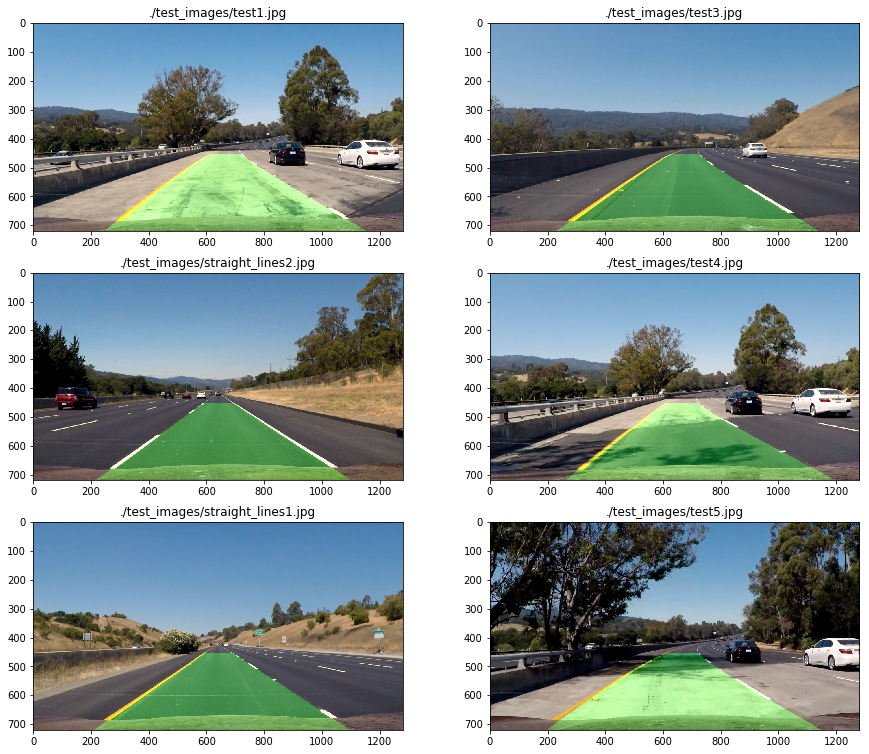

In [154]:
ouputs = list(map(lambda img:(img[0],drawLaneOnImage(img[1])),testImages))
showImages(ouputs, 2, 3, (15,13))

### Step 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [155]:
def pipeline(img, fontScale=2):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = detectLane(img)
    output = drawLine(img, left_fit, right_fit)
    
    # Calculate curvature
    leftCurvature = calculateCurvature(yRange, left_fit_m) 
    rightCurvature = calculateCurvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, fontScale, fontColor, 2)
    return output

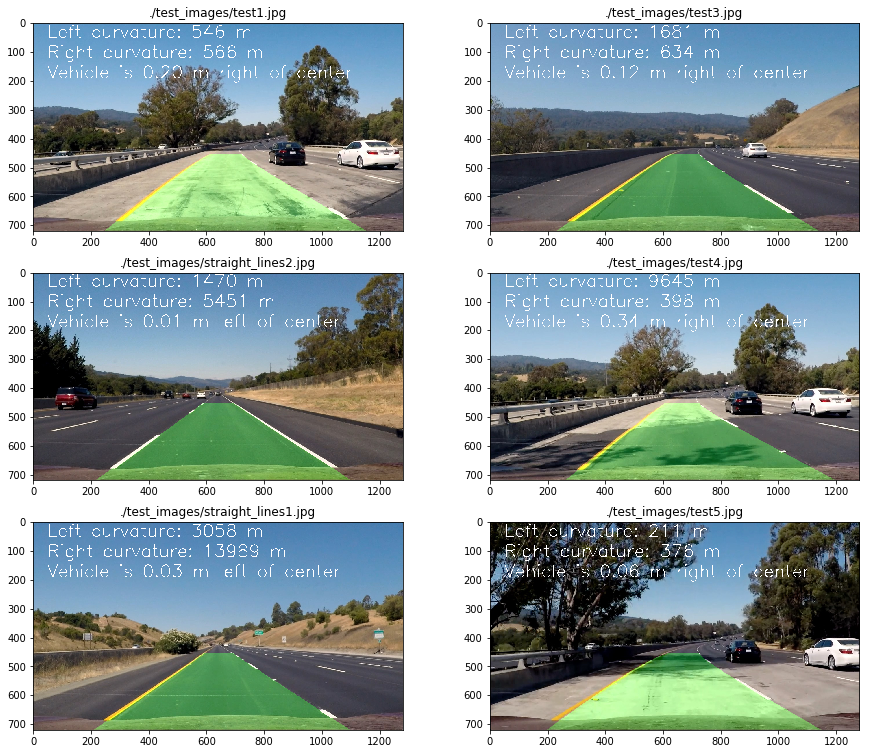

In [156]:
ouputs = list(map(lambda img:(img[0],pipeline(img[1])),testImages))
showImagesRGB(ouputs, 2, 3, (15,13))

### Step 9. Test on Video.

In [221]:
from moviepy.editor import VideoFileClip

class Lane():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_fit_m = None
        self.right_fit_m = None
        self.leftCurvature = None
        self.rightCurvature = None

def calculateLanes(img):
    """
    Calculates the lane on image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = detectLane(img)
    # Calculate curvature
    leftCurvature = calculateCurvature(yRange, left_fit_m) 
    rightCurvature = calculateCurvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)

def displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle):
    """
    Display the lanes information on the image.
    """
    output = drawLine(img, left_fit, right_fit)
    
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, 1, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, 1, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, 1, fontColor, 2)
    return output
    
def videoPipeline(inputVideo, outputVideo):
    """
    Process the `inputVideo` frame by frame to find the lane lines, draw curvarute and vehicle position information and
    generate `outputVideo`
    """
    myclip = VideoFileClip(inputVideo)
    
    leftLane = Lane()
    rightLane = Lane()
    
    def processImage(img):
        left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle = calculateLanes(img)
        if leftCurvature > 10000:
            left_fit = leftLane.left_fit
            left_fit_m = leftLane.left_fit_m
            leftCurvature = leftLane.leftCurvature
        else:
            leftLane.left_fit = left_fit
            leftLane.left_fit_m = left_fit_m
            leftLane.leftCurvature = leftCurvature
        
        if rightCurvature > 10000:
            right_fit = rightLane.right_fit
            right_fit_m = rightLane.right_fit_m
            rightCurvature = rightLane.rightCurvature
        else:
            rightLane.right_fit = right_fit
            rightLane.right_fit_m = right_fit_m
            rightLane.rightCurvature = rightCurvature
            
        return displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)

    clip = myclip.fl_image(processImage)
    clip.write_videofile(outputVideo, audio=False)

# Project video
videoPipeline('project_video.mp4', 'video_output/project_video.mp4')

[MoviePy] >>>> Building video video_output/project_video.mp4
[MoviePy] Writing video video_output/project_video.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<05:05,  4.12it/s]

  0%|          | 2/1261 [00:00<05:10,  4.05it/s]

  0%|          | 3/1261 [00:00<05:07,  4.09it/s]

  0%|          | 4/1261 [00:00<05:03,  4.14it/s]

  0%|          | 5/1261 [00:01<05:01,  4.17it/s]

  0%|          | 6/1261 [00:01<04:58,  4.20it/s]

  1%|          | 7/1261 [00:01<04:56,  4.23it/s]

  1%|          | 8/1261 [00:01<04:55,  4.24it/s]

  1%|          | 9/1261 [00:02<04:55,  4.24it/s]

  1%|          | 10/1261 [00:02<04:53,  4.26it/s]

  1%|          | 11/1261 [00:02<04:52,  4.27it/s]

  1%|          | 12/1261 [00:02<04:51,  4.28it/s]

  1%|          | 13/1261 [00:03<04:50,  4.29it/s]

  1%|          | 14/1261 [00:03<04:51,  4.28it/s]

  1%|          | 15/1261 [00:03<04:55,  4.22it/s]

  1%|▏         | 16/1261 [00:03<04:52,  4.25it/s]

  1%|▏         | 17/1261 [00:04<04:51,  4.26it/s]

  1%|▏         | 18/1261 [00:04<04:50,  4.28it/s]

  2%|▏         | 19/1261 [00:04<04:50,  4.27it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/project_video.mp4 



In [222]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('video_output/project_video.mp4'))